## **Introduction** 

<div class="alert alert-block alert-info">
<b> Project : 인적자원 관리를 위한 직원들의 번아웃 레벨 예측 모델 개발 </b> <br> 
    
   
    predict the employee burn out level
    Purpose : HR의 관점으로 임직원들의 정신 건강 상태를 관리의 목적

    
</div>

https://www.kaggle.com/competitions/mlx-stage-1-round-1-predict-students-marks

데이터 셋 : 
- Employee ID 직원 아이디 : The unique ID 유니크 키

- Date of Joining 근무시작일
- Gender 성별: (Male/Female) 남/녀
- Company Type 비즈니스 유형: (Service/Product) 서비스 / 제품(생산)
- WFH Setup Available 재택 여부: (Yes/No)
- Designation 직급
- Resource Allocation 근무시간
- Mental Fatigue Score 피로도
- Burn Rate 번아웃 수치

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
burnout = pd.read_csv('train.csv')

In [3]:
burnout.head(5)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


## **1. Dataset Description** 

In [6]:
burnout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [32]:
numeric_cols=burnout.select_dtypes(include='number').columns.tolist()
category_cols = burnout.select_dtypes(exclude=np.number).columns.tolist() 
print(f'nunumeric_cols = {numeric_cols}, \ncategory_cols = {category_cols}')

nunumeric_cols = ['Designation', 'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate', 'RelativeDaysJoined'], 
category_cols = ['Employee ID', 'Date of Joining', 'Gender', 'Company Type', 'WFH Setup Available', 'Burn Level']


In [8]:
# number of unique values per variable
burnout.nunique()

Employee ID             22750
Date of Joining           366
Gender                      2
Company Type                2
WFH Setup Available         2
Designation                 6
Resource Allocation        10
Mental Fatigue Score      101
Burn Rate                 101
dtype: int64

Gender, Company Type, WFH Setup Available 는 binary category 변수 <br>
-> 전처리 단계 : One-Hot Encoding 수행

In [9]:
#'Date of Joining'(근무시작일)의 범위 확인
burnout['Date of Joining'].agg(['min', 'max'])

min    2008-01-01
max    2008-12-31
Name: Date of Joining, dtype: object

-> This dataset contains information about employees who started working in 2018.


#### Let's check <b> the columns with missing values.</b>


In [9]:
burnout.isnull().sum()
#실수형 데이터 - 약 5%, 10%, 5%의 결측치 존재 -> 제거 or 치환?

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [10]:
#Designation 구간 : 0.0~5.0 / 구간 크기 1.0 씩 / 총 구간 : 6개
Desig = burnout['Designation'].unique()
np.sort(Desig)

array([0., 1., 2., 3., 4., 5.])

In [11]:
#Resource Allocation 구간 : 1.0~10.0 / 구간 크기 1.0 씩 / 총 구간 : 10개
RA = burnout['Resource Allocation'].unique()
np.sort(RA)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

In [11]:
#Mental Fatigue Score 구간 : 0.0~10.0 / 구간 크기 0.1씩  / 총 구간 : 101개 
MFS = burnout['Mental Fatigue Score'].unique()
print(len(MFS)) #결측값 +1
np.sort(MFS)

102


array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ,  nan])

In [12]:
#Burn Rate 구간 : 0.0~1.0 / 구간 크기 0.01씩 / 총 구간 : 101개
BR = burnout['Burn Rate'].unique()
print(len(BR)) #결측값 +1
np.sort(BR)

102


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ,  nan])

In [13]:
burnout.describe()
#실수형 데이터 이지만 구간값이 작고, 스케일이 비슷해서 -> 이상치와 스케일 차이는 신경 x

,Date of Joining,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750,22750.000000,21369.000000,20633.000000,21626.000000
mean,2008-07-01 09:28:05.274725120,2.178725,4.481398,5.728188,0.452005
min,2008-01-01 00:00:00,0.000000,1.000000,0.000000,0.000000
25%,2008-04-01 00:00:00,1.000000,3.000000,4.600000,0.310000
50%,2008-07-02 00:00:00,2.000000,4.000000,5.900000,0.450000
75%,2008-09-30 00:00:00,3.000000,6.000000,7.100000,0.590000
max,2008-12-31 00:00:00,5.000000,10.000000,10.000000,1.000000
std,NaN,1.135145,2.047211,1.920839,0.198226


## **2. Exploratory Data Analysis (EDA)** 

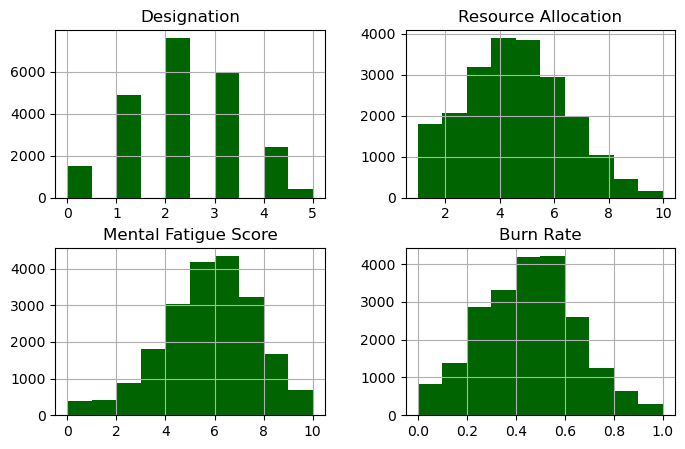

In [11]:
burnout[numeric_cols].hist(bins=10, figsize=(8,5), color='darkgreen');

In [15]:
#종형의 형태

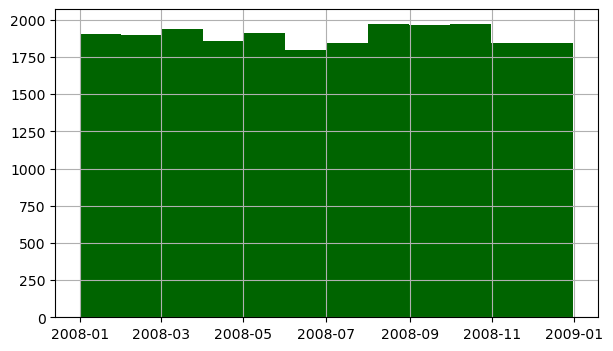

In [12]:
burnout['Date of Joining'].hist(bins=12, figsize=(7,4), color='darkgreen');

In [430]:
#균등분포의 형태

<Axes: >

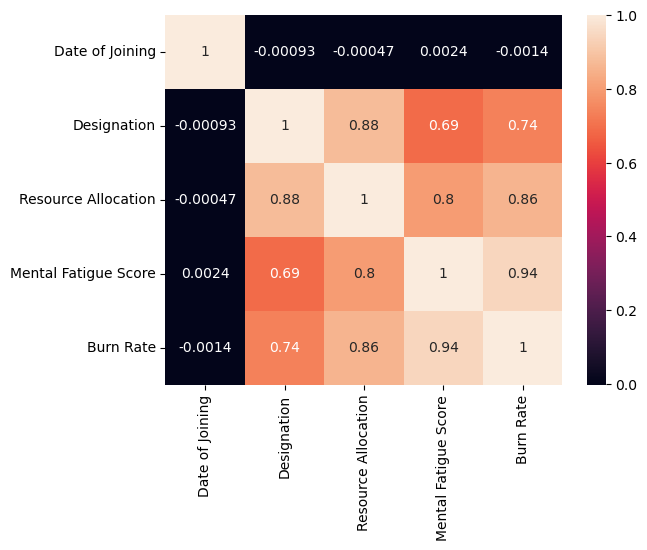

In [13]:
corr= burnout[['Date of Joining', 'Designation', 'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']].corr()
sns.heatmap(corr, annot=True)

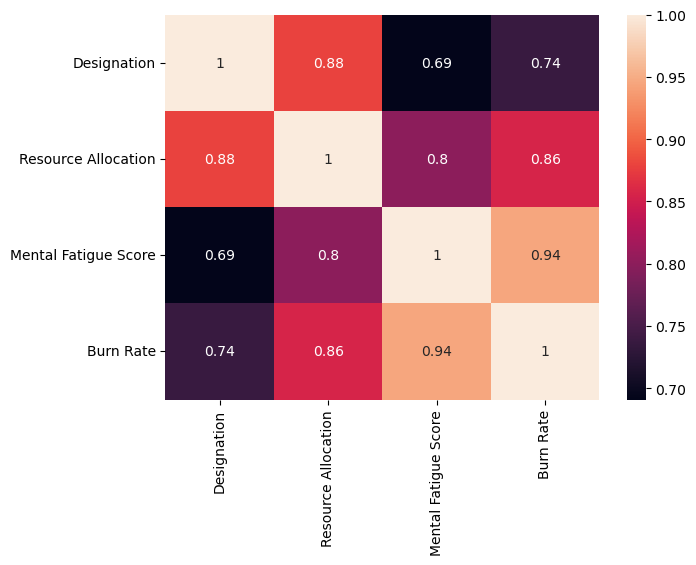

In [18]:
plt.figure(figsize=(7,5))
corr = burnout[numeric_cols].corr()
sns.heatmap(corr, annot=True)

plt.show()

In [23]:
burnout[['Designation', 'Resource Allocation']].groupby('Designation').value_counts()
#직급이 높아질수록 근무시간이 높아지는 양상 파악 
#근무시간의 결측치 -> 각 직급 그룹별 최빈값 대체 전략 

Designation  Resource Allocation
0.0          1.0                    1142
             2.0                     262
             3.0                      17
1.0          3.0                    1682
             2.0                    1475
             4.0                     735
             1.0                     635
             5.0                      59
2.0          4.0                    2564
             5.0                    2009
             3.0                    1479
             6.0                     652
             2.0                     338
             7.0                      52
             1.0                      14
3.0          6.0                    1952
             5.0                    1783
             7.0                    1056
             4.0                     594
             8.0                     224
             3.0                      14
             9.0                       7
4.0          7.0                     857
             8.0        

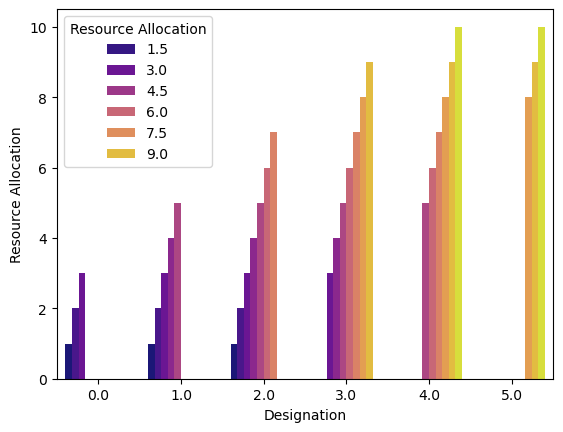

In [24]:
sns.barplot(y=burnout['Resource Allocation'], x=burnout['Designation'], palette='plasma', hue=burnout['Resource Allocation'], legend=True)
plt.show()

In [25]:
#근무시간별 피로도 요약 통계량
burnout[['Resource Allocation', 'Mental Fatigue Score']].groupby('Resource Allocation').describe()

Mental Fatigue Score                                     \
                                   count      mean       std  min  25%  50%   
Resource Allocation                                                           
1.0                               1625.0  2.475508  1.446540  0.0  1.3  2.6   
2.0                               1872.0  3.910363  1.339077  0.0  3.1  4.0   
3.0                               2903.0  4.817361  1.145745  1.0  4.0  4.9   
4.0                               3560.0  5.551826  1.118431  1.6  4.8  5.6   
5.0                               3530.0  6.199150  1.066953  3.2  5.5  6.2   
6.0                               2692.0  6.907355  1.044113  3.5  6.2  7.0   
7.0                               1769.0  7.503222  0.942586  5.2  6.8  7.5   
8.0                                952.0  8.123529  0.939446  5.4  7.5  8.1   
9.0                                410.0  8.773902  0.799894  7.0  8.2  8.8   
10.0                               141.0  9.219858  0.812599  7.1  8.7  9.5   

                                 
                      75%   max  
Resource Allocation              
1.0                   3.6   5.6  
2.0                   4.8   7.1  
3.0                   5.7   7.5  
4.0                   6.3   8.7  
5.0                   7.0   9.7  
6.0                   7.6  10.0  
7.0                   8.1  10.0  
8.0                   8.8  10.0  
9.0                   9.4  10.0  
10.0                 10.0  10.0

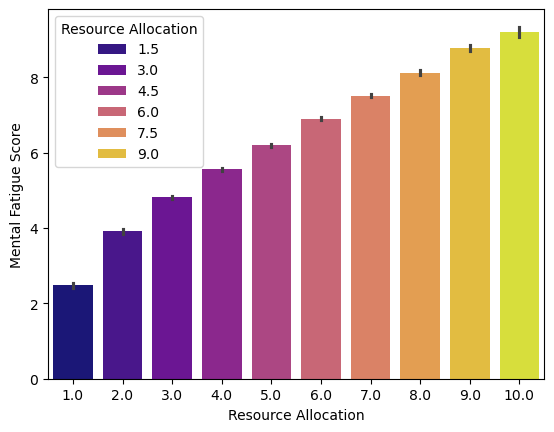

In [306]:
sns.barplot(y=burnout['Mental Fatigue Score'], x=burnout['Resource Allocation'], palette='plasma', hue=burnout['Resource Allocation'], legend=True)
plt.show()

#### 결측치 처리 방법 요약 
1. 타겟인 'Burn Rate' 삭제 (전체 데이터의 5%정도로 모델 생성에 지장 없을 것으로 판단)
   
2. 'Designation'는 'Resource Allocation'과 높은 상관관계; 0.88 <br>
   직급이 높아질수록 근무시간이 높아지는 양상 파악 <br>
   <b> Strategy: 각 직급별 근무시간의 최빈값 대체 </b>
   
3. 'Mental Fatigue Score'는 타겟을 제외한 'Resource Allocation'과 가장 높은 상관관계; 0.8 <br>
   <b> Strategy: 각 근무시간별 근무시간의 최빈값 대체 </b>

*** 각 Feature의 결측치를 최빈값으로 대체하는 이유: 연속형 변수이지만 일정한 구간값을 가진 카테고리 속성을 가진 Features임을 고려하여 
범주형 결측치 대체 전략인 최빈값을 사용 ***
   

## **3. Feature Engineering**

In [4]:
# 'Burn Rate' 열의 결측값이 있는 행 삭제
burnout.dropna(subset=['Burn Rate'], inplace=True)

In [5]:
burnout.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21626 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           21626 non-null  object 
 1   Date of Joining       21626 non-null  object 
 2   Gender                21626 non-null  object 
 3   Company Type          21626 non-null  object 
 4   WFH Setup Available   21626 non-null  object 
 5   Designation           21626 non-null  float64
 6   Resource Allocation   20348 non-null  float64
 7   Mental Fatigue Score  19681 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


#### 3-1. Handling Missing Values  파이프라인 결측치 처리 함수  

In [28]:
burnout.groupby('Designation')['Resource Allocation']

In [29]:
burnout.groupby('Designation')['Resource Allocation'].apply(lambda x: x.mode().iloc[0])

Designation
0.0    1.0
1.0    3.0
2.0    4.0
3.0    6.0
4.0    7.0
5.0    9.0
Name: Resource Allocation, dtype: float64

In [30]:
#전처리 파이프라인 함수 1.그룹별 최빈값 대체 
def impute_groupby_mode(df, group, nan_feature):
    # 그룹별 결측치 특성의 최빈값 계산
    df_copy = df.copy()
   
    # 그룹별 결측치 특성의 평균 계산
    impute_modes = burnout.groupby(group)[nan_feature].apply(lambda x: x.mode().iloc[0])

    # nan_feature의 값에 결측치를 group에 따른 nan_feature 최빈값으로 대체
    df_copy[nan_feature] = df_copy.apply(
        lambda row: impute_modes[row[group]] if pd.isna(row[nan_feature]) else row[nan_feature],
        axis=1
    )
    return df_copy

In [31]:
#시뮬레이션
burnout_imputed = impute_groupby_mode(burnout, 'Designation', 'Resource Allocation')
burnout_imputed.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation        0
Mental Fatigue Score    1945
Burn Rate                  0
dtype: int64

In [32]:
#시뮬레이션
burnout_imputed = impute_groupby_mode(burnout_imputed, 'Resource Allocation', 'Mental Fatigue Score')
burnout_imputed.isna().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

#### 3-2. Feature extraction - Date of Joining 

In [7]:
burnout['Date of Joining'] = pd.to_datetime(burnout['Date of Joining'])
burnout.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21626 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Employee ID           21626 non-null  object        
 1   Date of Joining       21626 non-null  datetime64[ns]
 2   Gender                21626 non-null  object        
 3   Company Type          21626 non-null  object        
 4   WFH Setup Available   21626 non-null  object        
 5   Designation           21626 non-null  float64       
 6   Resource Allocation   20348 non-null  float64       
 7   Mental Fatigue Score  19681 non-null  float64       
 8   Burn Rate             21626 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 1.6+ MB


In [8]:
#근무시작일 특성을 현재 날짜를 기준으로 근속일수 피쳐 생성하기

In [9]:
#기준일자로부터의 상대적인 일수로 계산하여 'RelativeDaysJoine' 피쳐 생성
#모든 데이터가 2018년도 데이터, 상대적인 일수 크기를 비교로 사용되는 변수이기 때문에 기준일자를 '2009-01-01'로 설정
from datetime import datetime

reference_date = datetime(2009, 1, 1)

burnout['RelativeDaysJoined'] = (reference_date - burnout['Date of Joining']).dt.days
burnout['RelativeDaysJoined'].describe()

count    21626.000000
mean       183.638444
std        105.383088
min          1.000000
25%         93.000000
50%        183.000000
75%        276.000000
max        366.000000
Name: RelativeDaysJoined, dtype: float64

In [10]:
len(burnout['RelativeDaysJoined'].unique())

366

In [11]:
burnout.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,RelativeDaysJoined
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16,93
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36,32
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49,297
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20,59
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52,161


#### 3-3. Target Binning "Burn Rate" - 4레벨

* Burn Rate 생성하는 이유 <br>
: *번아울 레벨로 범주화하여 직원의 번아웃 정도를 파악을 수월하고 관리에 편리하도록 <br>*
to be 직원들이 번아웃 등급을 매겨 직관적으로 상태를 확인할 수 있다. <br>

In [12]:
#'Burn Rate' 살펴보기

#Burn Rate 구간 : 0.0~1.0 / 구간 크기 0.01씩 / 총 구간 : 101개
BR = burnout['Burn Rate'].unique()
print(len(BR)) 
np.sort(BR)

101


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [13]:
#Target(Burn Rate) 0.0~ 1.0까지 0.1씩 구간화 -> 모델 예측할 특성인 Burn Level 특성 생성
bins = np.arange(0.0, 1.1, 0.25)
labels = np.arange(1, 5, 1)
print(f' bins = ({len(bins)}, {bins}), labels = ({len(labels)}, {labels})')

 bins = (5, [0.   0.25 0.5  0.75 1.  ]), labels = (4, [1 2 3 4])


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer

In [14]:
#Burn Level
burnout['Burn Level'] = pd.cut(burnout['Burn Rate'], bins=bins, labels=labels, include_lowest=True, right=True)
burnout['Burn Level'].unique()

[1, 2, 3, 4]
Categories (4, int32): [1 < 2 < 3 < 4]

In [15]:
#Burn Level 결측치 확인
burnout['Burn Level'].isna().sum()

0

In [17]:
burnout.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate', 'RelativeDaysJoined',
       'Burn Level'],
      dtype='object')

In [18]:
burnout[['Designation', 'Resource Allocation','Mental Fatigue Score', 'RelativeDaysJoined','Burn Level']].groupby('Burn Level', observed=True).describe().loc[:, (slice(None), ['mean', '50%','max'])]

Designation           Resource Allocation             \
                  mean  50%  max                mean  50%   max   
Burn Level                                                        
1             0.922970  1.0  3.0            1.892444  2.0   5.0   
2             1.900106  2.0  4.0            3.791065  4.0   7.0   
3             2.846047  3.0  5.0            5.992804  6.0  10.0   
4             3.866376  4.0  5.0            8.031538  8.0  10.0   

           Mental Fatigue Score            RelativeDaysJoined                
                           mean  50%   max               mean    50%    max  
Burn Level                                                                   
1                      2.746256  3.0   5.0         182.413793  181.0  366.0  
2                      5.301112  5.3   7.3         184.288017  183.0  366.0  
3                      7.170643  7.2   9.3         183.708016  183.0  366.0  
4                      8.880622  8.9  10.0         182.023239  183.0  366.0

#### **클래스(label) 분포 확인** 

In [19]:
#전체 데이터셋 클래스 분포
burnout['Burn Level'].value_counts().sort_index()

Burn Level
1    3596
2    9430
3    7223
4    1377
Name: count, dtype: int64

In [20]:
burnout['Burn Level'].value_counts().agg(['min', 'max'])

min    1377
max    9430
Name: count, dtype: int64

-> 클래스의 불균형을 가진다.

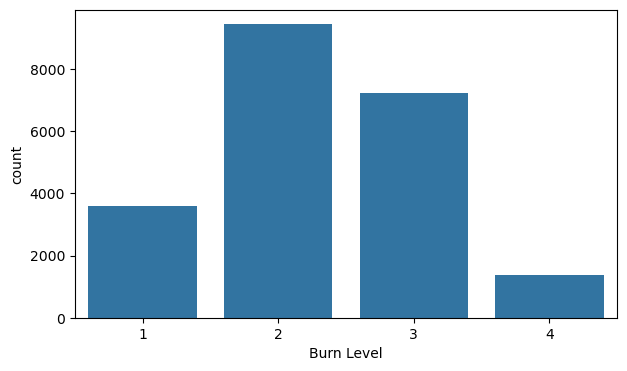

In [21]:
#전체 데이터셋(burnout) - 클래스 분포 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.countplot(x='Burn Level', data=burnout)  
plt.show()

##### 훈련 / 테스트 셋 클래스 분포

In [70]:
train_y_df = pd.DataFrame(train_y, columns=['Burn Level'])
vaild_y_df = pd.DataFrame(valid_y, columns=['Burn Level'])

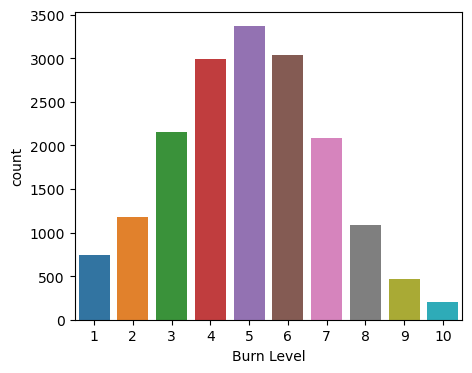

In [71]:
#훈련 데이터셋(train_y) - 클래스 분포 
plt.figure(figsize=(5,4))
sns.countplot(data=train_y_df, x='Burn Level')  
plt.show()

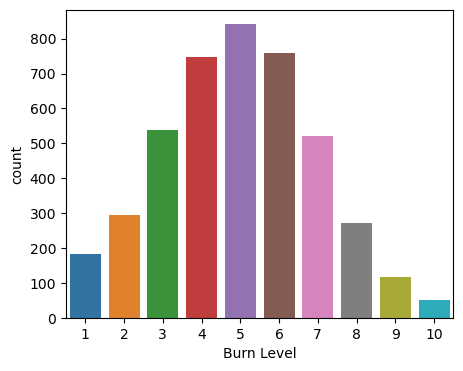

In [72]:
#검증 데이터셋(valid_y) - 클래스 분포 

plt.figure(figsize=(5,4))
sns.countplot(data=vaild_y_df, x='Burn Level')  
plt.show()

#### 3.4 Final EDA

target과 num_feature 관계 파악하기

In [53]:
target = 'Burn Rate'
feature_num = ['RelativeDaysJoined', 'Designation', 'Resource Allocation', 'Mental Fatigue Score']

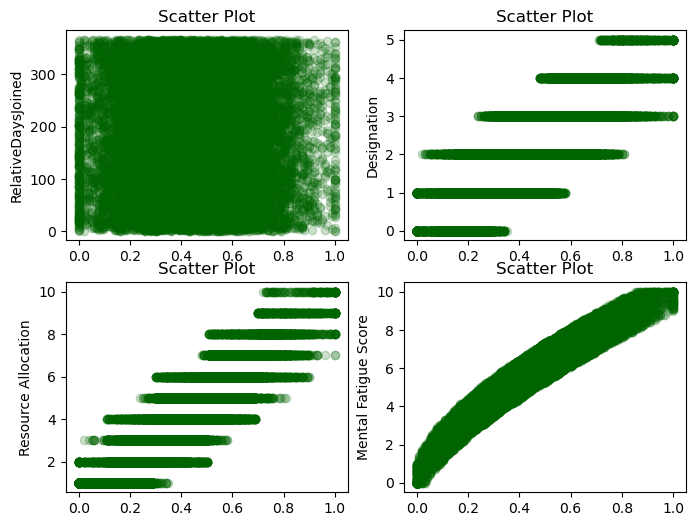

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

for i in range(2):
    for j in range(2):
        current_feature = feature_num[i * 2 + j]
        ax[i, j].scatter(data=burnout, x=target, y=current_feature,
                         marker='o', color='darkgreen', alpha=0.2)
        ax[i, j].set_title('Scatter Plot')
        ax[i, j].set_ylabel(current_feature)

plt.show()

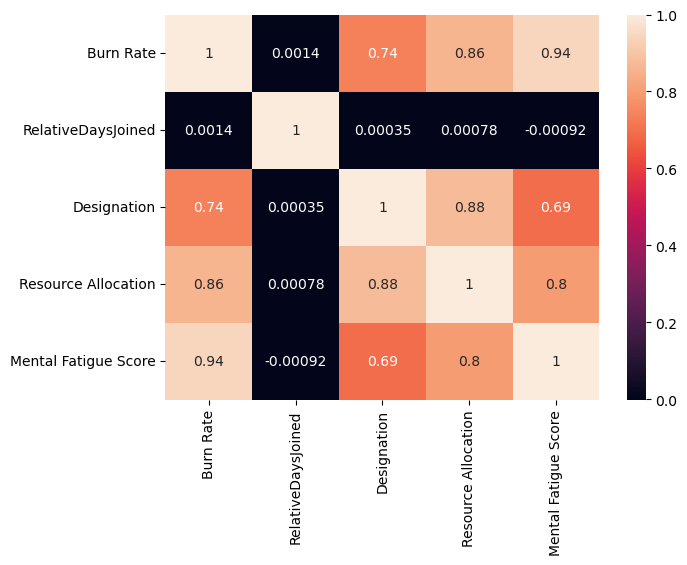

In [55]:
plt.figure(figsize=(7,5))
corr = burnout[[target] + feature_num].corr()
sns.heatmap(corr, annot=True)

plt.show()

- The 'Mental Fatigue Score' exhibits the strong positive correlation. 
- There seems to be week or no correlation with 'RelativeDaysJoined'.

#### 3-5 Key features and target variable

In [22]:
target = 'Burn Level'

#고유 식별자 컬럼 'Employee ID','RelativeDaysJoined' 제외
# Exclude the Employee ID column, considered as a unique identifier.
features = ['Gender', 'Company Type','WFH Setup Available','Designation', 'Resource Allocation', 'Mental Fatigue Score']
features

['Gender',
 'Company Type',
 'WFH Setup Available',
 'Designation',
 'Resource Allocation',
 'Mental Fatigue Score']

In [36]:
num_features = burnout[features].select_dtypes(include=np.number).columns.tolist() 
cat_features = burnout[features].select_dtypes(exclude=np.number).columns.tolist() 

In [37]:
num_features

['Designation', 'Resource Allocation', 'Mental Fatigue Score']

In [38]:
cat_features

['Gender', 'Company Type', 'WFH Setup Available']

### **SMOTE resampling**

In [59]:
# pip install imbalanced-learn

In [23]:
import imblearn

In [24]:
burnout[target].unique()

[1, 2, 3, 4]
Categories (4, int32): [1 < 2 < 3 < 4]

In [27]:
from collections import Counter
counter = Counter(burnout[target])
print("원본 클래스의 비율: ", counter)

원본 클래스의 비율:  Counter({2: 9430, 3: 7223, 1: 3596, 4: 1377})


In [28]:
counter.items() #클래스, 클래스 갯수

dict_items([(1, 3596), (2, 9430), (3, 7223), (4, 1377)])

In [29]:
burnout[target] #1차원 시리즈

0        1
1        2
2        2
3        1
4        3
        ..
22745    2
22746    3
22747    3
22748    3
22749    3
Name: Burn Level, Length: 21626, dtype: category
Categories (4, int32): [1 < 2 < 3 < 4]

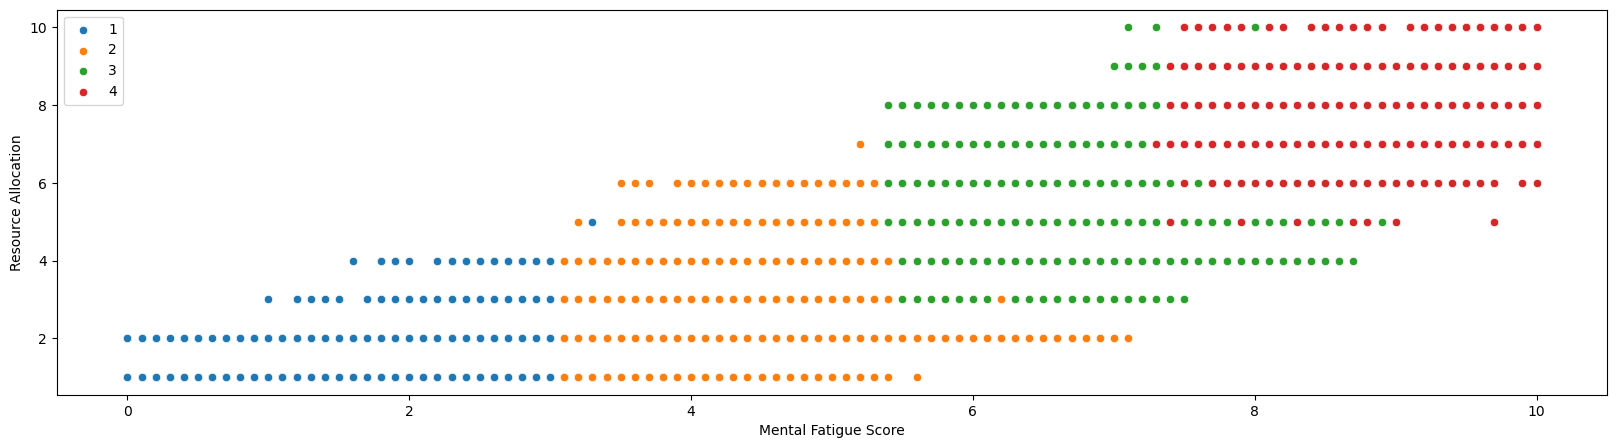

In [30]:
from numpy import where

fig, ax = plt.subplots(1,1 ,figsize=(20, 5))
for cnt, label in enumerate(counter.keys()):
    #print(label, _)
    row_ix = where(burnout[target] == label)[0]
    # print(burnout["Designation"].iloc[row_ix])
    sns.scatterplot(x=burnout["Mental Fatigue Score"].iloc[row_ix], y=burnout['Resource Allocation'].iloc[row_ix], ax=ax, label=label)
plt.legend(loc='upper left')
plt.show()

In [105]:
burnout[features].head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,Female,Service,No,2.0,3.0,3.8
1,Male,Service,Yes,1.0,2.0,5.0
2,Female,Product,Yes,2.0,NaN,5.8
3,Male,Service,Yes,1.0,1.0,2.6
4,Female,Service,No,3.0,7.0,6.9


In [97]:
#sns.scatterplot(x=burnout["Mental Fatigue Score"], y=burnout['Resource Allocation'], hue=burnout[target] )

In [39]:
#SMOTE 리샘플링의 조건 1. 모두 연속형 변수여야함 / 변수형 > 더미 인코딩
#범주형 변수 더미변수로 변환
features_dummies = pd.get_dummies(burnout[features], columns=cat_features)

In [40]:
features_dummies.head()

,Designation,Resource Allocation,Mental Fatigue Score,Gender_Female,Gender_Male,Company Type_Product,Company Type_Service,WFH Setup Available_No,WFH Setup Available_Yes
0,2.0,3.0,3.8,True,False,False,True,True,False
1,1.0,2.0,5.0,False,True,False,True,False,True
2,2.0,NaN,5.8,True,False,True,False,False,True
3,1.0,1.0,2.6,False,True,False,True,False,True
4,3.0,7.0,6.9,True,False,False,True,True,False


In [119]:
#SMOTE 리샘플링의 조건 2. 결측치가 포함되면 안됨

In [41]:
#전처리 파이프라인 함수 1.그룹별 최빈값 대체 
def impute_groupby_mode(df, group, nan_feature):
    # 그룹별 결측치 특성의 최빈값 계산
    df_copy = df.copy()
   
    # 그룹별 결측치 특성의 평균 계산
    impute_modes = burnout.groupby(group)[nan_feature].apply(lambda x: x.mode().iloc[0])

    # nan_feature의 값에 결측치를 group에 따른 nan_feature 최빈값으로 대체
    df_copy[nan_feature] = df_copy.apply(
        lambda row: impute_modes[row[group]] if pd.isna(row[nan_feature]) else row[nan_feature],
        axis=1
    )
    return df_copy

In [42]:
#시뮬레이션1
features_dummies = impute_groupby_mode(features_dummies, 'Designation', 'Resource Allocation')
features_dummies.isna().sum()

Designation                   0
Resource Allocation           0
Mental Fatigue Score       1945
Gender_Female                 0
Gender_Male                   0
Company Type_Product          0
Company Type_Service          0
WFH Setup Available_No        0
WFH Setup Available_Yes       0
dtype: int64

In [43]:
#시뮬레이션2
features_dummies = impute_groupby_mode(features_dummies, 'Resource Allocation', 'Mental Fatigue Score')
features_dummies.isna().sum()

Designation                0
Resource Allocation        0
Mental Fatigue Score       0
Gender_Female              0
Gender_Male                0
Company Type_Product       0
Company Type_Service       0
WFH Setup Available_No     0
WFH Setup Available_Yes    0
dtype: int64

In [44]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42, sampling_strategy='not majority',  k_neighbors=5)
features_smt, target_smt = smt.fit_resample(features_dummies, burnout[target])

In [45]:
#리샘플링 비율 확인 최대 데이터; 9430으로 맞춰짐
counter = Counter(target_smt)
print(counter)

Counter({1: 9430, 2: 9430, 3: 9430, 4: 9430})


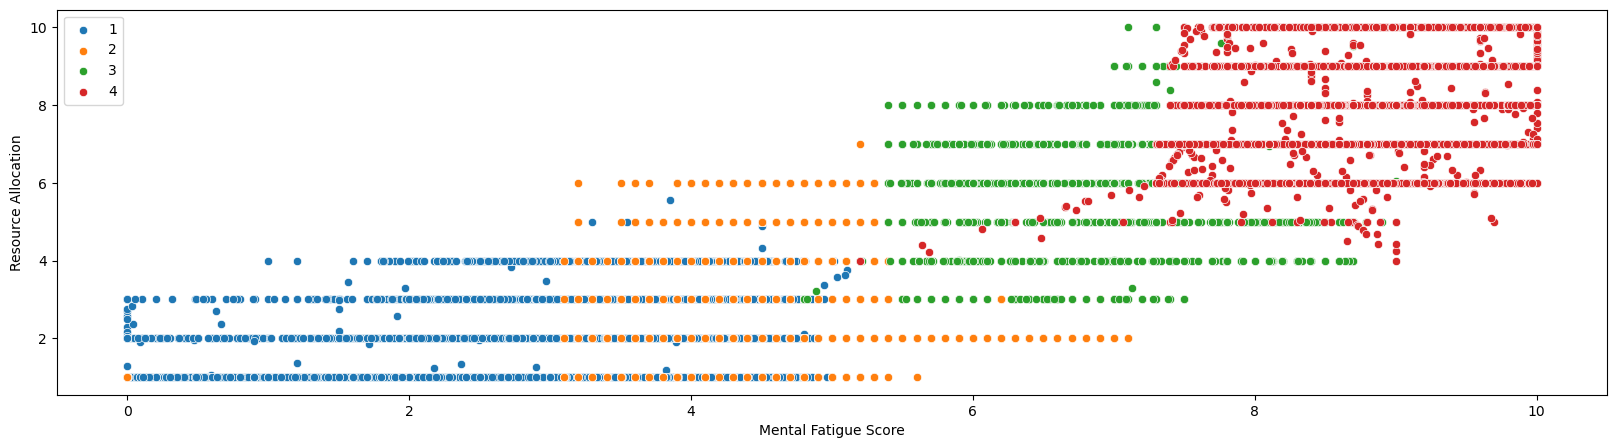

In [46]:
#시각화

fig, ax = plt.subplots(1,1 ,figsize=(20, 5))
for label in counter.keys():
    row_ix = where(target_smt == label)[0]
    sns.scatterplot(x=features_smt["Mental Fatigue Score"].iloc[row_ix], y=features_smt['Resource Allocation'].iloc[row_ix], ax=ax, label=label)
plt.legend(loc='upper left')
plt.show()

> 노이즈가 추가됨

####  SMOTE- features_smt, target_smt **Split train/test**

In [47]:
from sklearn.model_selection import train_test_split

#레이블을 기준으로 계층적 샘플링. 학습용과 검증용 데이터셋에서 각 레이블의 분포가 유지
train_X_smt , test_X_smt, train_y_smt, test_y_smt = \
train_test_split(features_smt, target_smt, test_size=0.2, random_state=42, stratify=target_smt)

##### 훈련 / 테스트 셋 클래스 분포

In [49]:
train_y_smt_df = pd.DataFrame(train_y_smt, columns=['Burn Level'])
test_y_smt_df = pd.DataFrame(test_y_smt, columns=['Burn Level'])

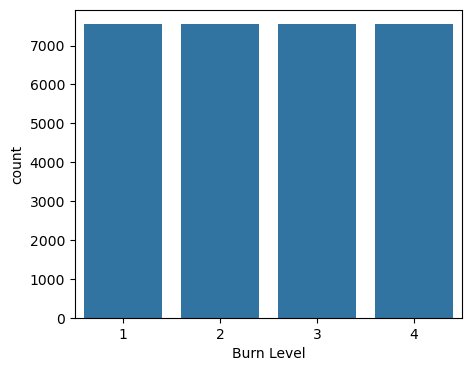

In [50]:
#훈련 데이터셋(train_y) - 클래스 분포 
plt.figure(figsize=(5,4))
sns.countplot(data=train_y_smt_df, x='Burn Level')  
plt.show()

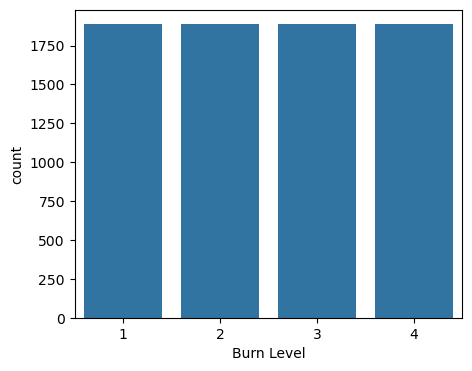

In [51]:
#검증 데이터셋(valid_y) - 클래스 분포 

plt.figure(figsize=(5,4))
sns.countplot(data=test_y_smt_df, x='Burn Level')  
plt.show()

In [57]:
train_X_smt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30176 entries, 4697 to 18633
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Designation              30176 non-null  float64
 1   Resource Allocation      30176 non-null  float64
 2   Mental Fatigue Score     30176 non-null  float64
 3   Gender_Female            30176 non-null  bool   
 4   Gender_Male              30176 non-null  bool   
 5   Company Type_Product     30176 non-null  bool   
 6   Company Type_Service     30176 non-null  bool   
 7   WFH Setup Available_No   30176 non-null  bool   
 8   WFH Setup Available_Yes  30176 non-null  bool   
dtypes: bool(6), float64(3)
memory usage: 1.1 MB


In [60]:
train_X_smt

,Designation,Resource Allocation,Mental Fatigue Score,Gender_Female,Gender_Male,Company Type_Product,Company Type_Service,WFH Setup Available_No,WFH Setup Available_Yes
4697,2.0,3.0,3.900000,True,False,True,False,False,True
32243,4.0,9.0,9.773168,False,True,False,True,False,True
24314,1.0,3.0,3.609235,False,True,True,False,False,True
30966,4.0,8.0,9.831040,True,False,True,False,True,False
2233,0.0,1.0,0.000000,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...
10402,1.0,2.0,4.800000,False,True,True,False,False,True
12463,2.0,3.0,4.800000,True,False,True,False,False,True
3223,1.0,2.0,6.300000,True,False,True,False,False,True
28559,2.0,5.0,7.800000,False,True,False,True,True,False


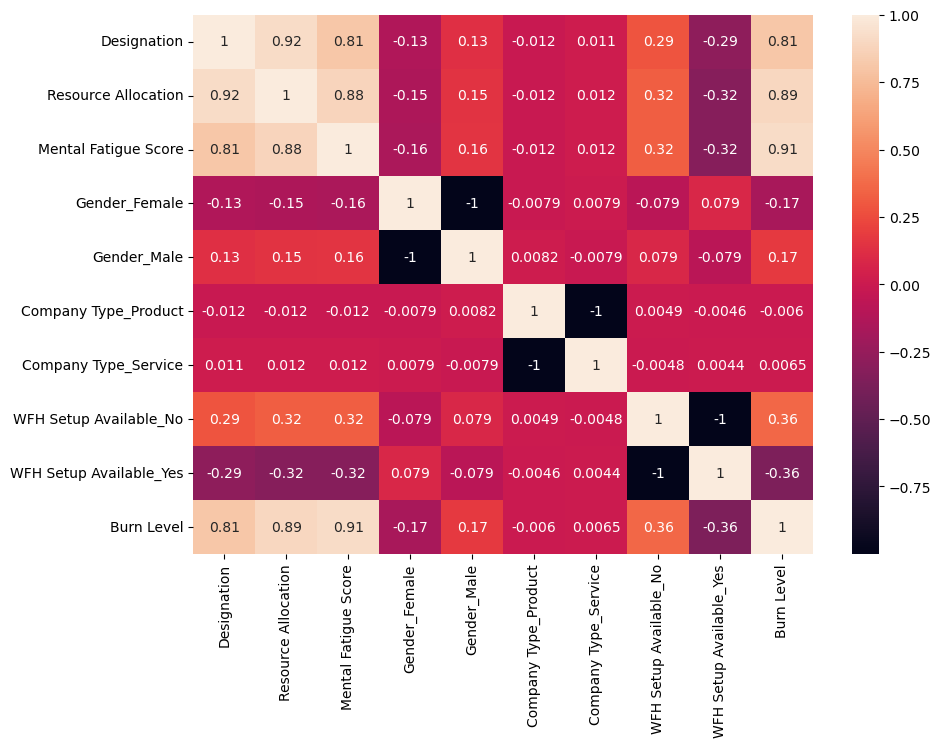

In [66]:
plt.figure(figsize=(10,7))
corr = pd.concat([train_X_smt, train_y_smt], axis=1).corr()
sns.heatmap(corr, annot=True)

plt.show()

#### **SMOTE - rfc Model** 

##### pipeline

In [52]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [67]:
num_features

['Designation', 'Resource Allocation', 'Mental Fatigue Score']

In [69]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features)], 
    remainder ='passthrough'
)        

In [70]:
from sklearn.ensemble import RandomForestClassifier

# '전처리-모델학습'의 full pipeline - 랜덤포레스트 파이프라인 정의
RFCmodel_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

In [71]:
RFCmodel_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Designation',
                                                   'Resource Allocation',
                                                   'Mental Fatigue Score'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [72]:
RFCmodel_pipeline.fit(train_X_smt, train_y_smt)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Designation',
                                                   'Resource Allocation',
                                                   'Mental Fatigue Score'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [73]:
RFCmodel_pipeline.score(train_X_smt, train_y_smt)

0.9231177094379639

In [77]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold

# 교차 검증을 위한 StratifiedKFold 사용 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 탐색할 하이퍼파라미터 설정
param_dist = {

    #'clf__max_depth': np.arange(6, 8, 10),
    #'clf__min_samples_leaf': np.arange(8, 12, 18),
    #'clf__min_samples_split': np.arange(8, 16, 20),
    #'clf__n_estimators': np.arange(50, 200, 50)

    
    'model__n_estimators': np.arange(100, 200, 50),
    'model__max_depth': np.arange(1,10,1),
    'model__min_samples_split': np.arange(2,20,4),
    'model__min_samples_leaf': np.arange(2,20,2),
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 찾기 (n_jobs=-1로 병렬 처리 활성화)
random_search = RandomizedSearchCV(
    RFCmodel_pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)

random_search.fit(train_X_smt, train_y_smt)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)
print('Score: ', random_search.best_score_)

최적의 하이퍼파라미터: {'model__n_estimators': 100, 'model__min_samples_split': 14, 'model__min_samples_leaf': 16, 'model__max_depth': 9}
Score:  0.8618109679399438


## **4. Split train data / test data**

In [37]:
from sklearn.model_selection import train_test_split

#레이블을 기준으로 계층적 샘플링. 학습용과 검증용 데이터셋에서 각 레이블의 분포가 유지
train_X , valid_X, train_y, valid_y = \
train_test_split(burnout[features], burnout[target], test_size=0.2, random_state=42, stratify=burnout[target])

In [38]:
#X-DataFrame
print(f'train_X = {train_X.shape}, valid_X ={valid_X.shape}')
type(train_X)

train_X = (17300, 6), valid_X =(4326, 6)


pandas.core.frame.DataFrame

In [39]:
#y-Series
print(f'train_y = {train_y.shape}, valid_y ={valid_y.shape}')
type(train_y)

train_y = (17300,), valid_y =(4326,)


pandas.core.series.Series

## **Class imbalance 클래스 불균형** 

<div class="alert alert-block alert-info">
<b> Cost Sensitive Learning을 활용한 데이터 불균형 문제 해결하기 <br>
 </b> 
 <br>
데이터 자체를 생성하지 않지만 머신러닝 학습할 때 소수의 클래스에 대한 cost값에 가중치를 더 많이 주어 균형 잡힌 학습이 가능하게 하는 방법 <br>
Weight balancing 라고도 하며,Class 수가 2:8로 이루어져있다면, loss에 대해 Weight 가중치를 8:2로 설정하여 학습하는 방법이다.

    
</div>

In [226]:
def print_class_count_ratio(labels):
    """
    데이터셋에서 클래스 갯수와 비율을 출력하는 함수 

    Parameters:
    - labels: 클래스 레이블이 담긴 배열
    
    Returns:
    - None (출력만 수행)

    """
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)

    print("클래스\t갯수\t비중")
    for class_label, count in zip(unique_classes, class_counts):
        class_weight = count / total_samples
        print(f"{class_label}\t{count}\t{class_weight:.2f}")


In [227]:
print_class_count_ratio(train_y)

클래스	갯수	비중
0	738	0.04
1	1180	0.07
2	2153	0.12
3	2985	0.17
4	3364	0.19
5	3033	0.18
6	2089	0.12
7	1088	0.06
8	463	0.03
9	207	0.01


In [228]:
print_class_count_ratio(valid_y)

클래스	갯수	비중
0	184	0.04
1	295	0.07
2	539	0.12
3	747	0.17
4	841	0.19
5	758	0.18
6	522	0.12
7	272	0.06
8	116	0.03
9	52	0.01


In [222]:
def calculate_class_weights(labels):
    """
    데이터셋에서 클래스 가중치를 계산하는 함수 
    
    Parameters:
    - labels: 클래스 레이블이 담긴 배열

    Returns:
    - class_weights: 각 클래스에 대한 가중치 딕셔너리
    """
    total_samples = len(labels)
    #각 클래스와 클래스의 갯수
    unique_classes, class_counts = np.unique(labels, return_counts=True)

    class_weights = {}
    for class_label, count in zip(unique_classes, class_counts):
        class_weights[class_label] = total_samples / (len(unique_classes) * count)

    return class_weights

In [237]:
#모델 학습시 사용할 클래스 가중치 
weights = calculate_class_weights(train_y)
weights

{0: 2.3441734417344176,
 1: 1.4661016949152543,
 2: 0.8035299581978634,
 3: 0.5795644891122278,
 4: 0.514268727705113,
 5: 0.5703923508077811,
 6: 0.8281474389660124,
 7: 1.5900735294117647,
 8: 3.736501079913607,
 9: 8.357487922705314}

#### 랜덤 포레스트 모델 적용

In [250]:
#최적의 파라미터 - best model 
#특성 1개 제거 

#best params = {'model__max_depth': 7, 'model__min_samples_leaf': 15, 'model__min_samples_split': 12, 'model__n_estimators': 81}

RFCmodel_pipeline_weights = Pipeline([
    ('imputer_na', impute_NA_pipeline),
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(max_depth=7, min_samples_leaf=15, min_samples_split=12, n_estimators=81, random_state=42, class_weight=weights))
])

In [251]:
RFCmodel_pipeline_weights.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RelativeDaysJoined',
                                                   'Designation',
                                                   'Mental...
                                                   'WFH Setup Available'])])),
                ('model',
                 RandomForestClassifier(class_weight={0: 2.3441734417344176,
                                                      1: 1.4661016949152543,
                                                      2: 0.8035299581978634,
                                                      3: 0.5795644891122278,
                                                      4: 0.514268727705113,
                                                      5: 0.5703923508077811,
                                                      6: 0.8281474389660124,
                                                      7: 1.5900735294117647,
                                                      8: 3.736501079913607,
                                                      9: 8.357487922705314},
                                        max_depth=7, min_samples_leaf=15,
                                        min_samples_split=12, n_estimators=81,
                                        random_state=42))])

In [252]:
RFCmodel_pipeline_weights.score(train_X, train_y)

0.536878612716763

In [253]:
RFCmodel_pipeline_weights.score(valid_X, valid_y)

0.49167822468793343

In [254]:
train_pred = RFCmodel_pipeline_weights.predict(train_X)
train_pred_proba = RFCmodel_pipeline_weights.predict_proba(train_X)
evaluate_multiclass_model(train_y, train_pred_proba, train_pred)

Accuracy: 0.5369
Precision: 0.5392
Recall: 0.5369
F1 Score: 0.5357
Log Loss: 1.1539
Confusion Matrix:
[[ 619  101   13    5    0    0    0    0    0    0]
 [ 145  747  263   24    1    0    0    0    0    0]
 [  32  336 1323  413   47    2    0    0    0    0]
 [   0    8  713 1378  701  172   13    0    0    0]
 [   0    0   63  730 1885  635   49    2    0    0]
 [   0    0    1   75  526 1605  613  208    5    0]
 [   0    0    0    9  151  455  817  540  117    0]
 [   0    0    0    1    6   47  207  513  262   52]
 [   0    0    0    0    0    2   10   84  227  140]
 [   0    0    0    0    0    0    1    3   29  174]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       738
           1       0.63      0.63      0.63      1180
           2       0.56      0.61      0.58      2153
           3       0.52      0.46      0.49      2985
           4       0.57      0.56      0.56      3364
           5       

## **5. Preprocessing and Model Fitting Pipeline**

In [73]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#### **5-1. preprocessing**

In [456]:
#전처리 파이프라인 
#1. 연속형 변수 -> 결측치 대체(각 상관관계 그룹별 최빈값), 정규화
#2. 카테고리 변수 -> 원핫 인코딩 

In [107]:
numeric_features = burnout[features].select_dtypes(include='number').columns.tolist()
categorical_features = burnout[features].select_dtypes(exclude='number').columns.tolist()
print('numeric_features: ', numeric_features,
      'categorical_features: ',categorical_features, sep='\n')

numeric_features: 
['Designation', 'Resource Allocation', 'Mental Fatigue Score']
categorical_features: 
['Gender', 'Company Type', 'WFH Setup Available']


In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

class ImputeGroupbyMode(BaseEstimator, TransformerMixin):
    def __init__(self, group, nan_feature):
        self.group = group
        self.nan_feature = nan_feature

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # 그룹별 결측치 특성의 최빈값 계산
        impute_modes = X.groupby(self.group)[self.nan_feature].apply(lambda x: x.mode().iloc[0])

        # nan_feature의 값에 결측치를 group에 따른 nan_feature 최빈값으로 대체
        X[self.nan_feature] = X.apply(
            lambda row: impute_modes[row[self.group]] if pd.isna(row[self.nan_feature]) else row[self.nan_feature],
            axis=1
        )

        return X

In [76]:
copy_df2 = burnout.copy()
a = ImputeGroupbyMode(group='Designation', nan_feature='Resource Allocation')

In [78]:
a.fit(copy_df2)

ImputeGroupbyMode(group='Designation', nan_feature='Resource Allocation')

In [79]:
copy_df2.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1278
Mental Fatigue Score    1945
Burn Rate                  0
RelativeDaysJoined         0
Burn Level                 0
dtype: int64

In [80]:
a.fit_transform(copy_df2)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,RelativeDaysJoined,Burn Level
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16,93,2
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36,32,4
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,4.0,5.8,0.49,297,5
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20,59,2
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52,161,6
...,...,...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,1.0,3.0,NaN,0.41,2,5
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,3.0,6.0,6.7,0.59,348,6
22747,fffe390032003000,2008-11-05,Male,Service,Yes,3.0,7.0,NaN,0.72,57,8
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,2.0,5.0,5.9,0.52,357,6


In [82]:
copy_df2.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation        0
Mental Fatigue Score    1945
Burn Rate                  0
RelativeDaysJoined         0
Burn Level                 0
dtype: int64

#### **5-2 pipeline design**

In [83]:
#1. 결측치 그룹별 대체 파이프라인 

impute_NA_pipeline = Pipeline([
    ('impute_RA', ImputeGroupbyMode(group='Designation', nan_feature='Resource Allocation')),
    ('impute_MF', ImputeGroupbyMode(group='Resource Allocation', nan_feature='Mental Fatigue Score'))
])

In [84]:
impute_NA_pipeline

Pipeline(steps=[('impute_RA',
                 ImputeGroupbyMode(group='Designation',
                                   nan_feature='Resource Allocation')),
                ('impute_MF',
                 ImputeGroupbyMode(group='Resource Allocation',
                                   nan_feature='Mental Fatigue Score'))])

In [85]:
impute_NA_pipeline.fit_transform(train_X)

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
14761,Male,Product,No,4.0,8.0,8.6
12006,Male,Service,No,2.0,6.0,7.6
6922,Female,Product,Yes,1.0,4.0,7.0
10185,Male,Service,No,4.0,7.0,6.7
6013,Female,Service,No,1.0,3.0,3.9
...,...,...,...,...,...,...
9667,Male,Service,Yes,3.0,7.0,6.3
14842,Male,Product,No,2.0,4.0,6.2
7185,Male,Service,Yes,2.0,5.0,4.4
19702,Male,Service,Yes,1.0,4.0,6.2


In [86]:
#결과 확인
train_X.isna().sum()

Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

In [87]:
# 특성 제거전 
# 2. 나머지 전처리 과정 파이프라인 - preprocessor 
# ColumnTransformer에 적용

preprocessor_PRE = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # 연속형 변수에 대한 스케일링
        ('cat', OneHotEncoder(), categorical_features)], # 카테고리 변수에 대한 원핫인코딩  
        
         remainder='drop'  
)

In [88]:
# 2. 나머지 전처리 과정 파이프라인 - preprocessor 
# ColumnTransformer에 적용
# 독립변수간 상관관계가 큰 값 Resource Allocation 삭제

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in numeric_features if col != 'Resource Allocation']),  # 연속형 변수에 대한 스케일링
        ('cat', OneHotEncoder(), categorical_features)], # 카테고리 변수에 대한 원핫인코딩  
        
         remainder='drop'  # 나머지 열은 드랍; 'Resource Allocation' 제거됨
)

## **6. Training the Models**

### 6-1 **Full pipeline - RandomForestClassifier**

In [89]:
from sklearn.ensemble import RandomForestClassifier

# '전처리-모델학습'의 full pipeline - 랜덤포레스트 파이프라인 정의
RFCmodel_pipeline = Pipeline([
    ('imputer_na', impute_NA_pipeline),
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

In [90]:
RFCmodel_pipeline

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Designation',
                                                   'Mental Fatigue Score']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Gender', 'Company Type',
                                                   'WFH Setup Available'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [91]:
RFCmodel_pipeline.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Designation',
                                                   'Mental Fatigue Score']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Gender', 'Company Type',
                                                   'WFH Setup Available'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [92]:
#전처리된 Features 확인 
preprocessor.fit_transform(train_X)
preprocessor.get_feature_names_out()

array(['num__Designation', 'num__Mental Fatigue Score',
       'cat__Gender_Female', 'cat__Gender_Male',
       'cat__Company Type_Product', 'cat__Company Type_Service',
       'cat__WFH Setup Available_No', 'cat__WFH Setup Available_Yes'],
      dtype=object)

연속형 변수 3개(1개 제외), 범주형 3개 one-hot * 2 = 총 6개 <br>
9개의 features 

In [93]:
#파이프라인 전처리 잘 됬는지 확인

transformed_data = RFCmodel_pipeline.named_steps['preprocessing'].fit_transform(train_X)
transformed_X_df = pd.DataFrame(transformed_data)
transformed_X_df

,0,1,2,3,4,5,6,7
0,1.606280,1.484932,0.0,1.0,1.0,0.0,1.0,0.0
1,-0.159311,0.969197,0.0,1.0,0.0,1.0,1.0,0.0
2,-1.042107,0.659756,1.0,0.0,1.0,0.0,0.0,1.0
3,1.606280,0.505036,0.0,1.0,0.0,1.0,1.0,0.0
4,-1.042107,-0.939022,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
17295,0.723484,0.298742,0.0,1.0,0.0,1.0,0.0,1.0
17296,-0.159311,0.247168,0.0,1.0,1.0,0.0,1.0,0.0
17297,-0.159311,-0.681155,0.0,1.0,0.0,1.0,0.0,1.0
17298,-1.042107,0.247168,0.0,1.0,0.0,1.0,0.0,1.0


#### 6-1-1 rfc model scoring

In [94]:
burnout_predictions = RFCmodel_pipeline.predict(valid_X)
burnout_predictions

array([5, 8, 7, ..., 7, 5, 5])

In [95]:
# 모델을 훈련 데이터에 맞추기
RFCmodel_pipeline.fit(train_X, train_y)

# 훈련 데이터에 대한 예측 수행
train_pred = RFCmodel_pipeline.predict(train_X)

# 정확도 계산
accuracy = accuracy_score(train_y, train_pred)
print(f'accuracy = {accuracy}')

NameError: name 'accuracy_score' is not defined

In [156]:
# 모델을 훈련 데이터에 맞추기
RFCmodel_pipeline.fit(valid_X, valid_y)

# 훈련 데이터에 대한 예측 수행
valid_pred = RFCmodel_pipeline.predict(valid_X)

# 정확도 계산
accuracy = accuracy_score(valid_y, valid_pred)
print(f'accuracy = {accuracy}')

accuracy = 0.9965325936199723


In [96]:
RFCmodel_pipeline.score(train_X, train_y)

0.6142774566473989

In [97]:
RFCmodel_pipeline.score(valid_X, valid_y)

0.5106333795654184

-> 과적합

In [98]:
# RFCmodel_pipeline에서 랜덤 포레스트 분류기 객체 얻기
rfc= RFCmodel_pipeline.named_steps['model']

# 피쳐 중요도 확인
feature_importance = rfc.feature_importances_

# 각 피쳐의 중요도 출력
for feature, importance in zip(features, feature_importance):
    print(f"{feature}: {importance}")

Gender: 0.14739437996469748
Company Type: 0.795774429894506
WFH Setup Available: 0.005379227589206458
Designation: 0.005250928771456743
Resource Allocation: 0.0025720550620101992
Mental Fatigue Score: 0.0025361073179623536


--------
원인 찾기 1. 독립 변수들 간의 상관관계 확인 <br>
 <b> 1. 제거할 불필요한 features  </b>

##### 특성 제거전

In [299]:
from sklearn.ensemble import RandomForestClassifier
#특성 제거전
# '전처리-모델학습'의 full pipeline - 랜덤포레스트 파이프라인 정의
RFCmodel_pipeline_PRE = Pipeline([
    ('imputer_na', impute_NA_pipeline),
    ('preprocessing', preprocessor_PRE),
    ('model', RandomForestClassifier(random_state=42))
])

In [300]:
RFCmodel_pipeline_PRE.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RelativeDaysJoined',
                                                   'Designation',
                                                   'Resource Allocation',
                                                   'Mental Fatigue Score']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Gender', 'Company Type',
                                                   'WFH Setup Available'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [301]:
#전처리된 Features 확인 - 10개
preprocessor_PRE.fit_transform(train_X)
preprocessor_PRE.get_feature_names_out()

array(['num__RelativeDaysJoined', 'num__Designation',
       'num__Resource Allocation', 'num__Mental Fatigue Score',
       'cat__Gender_Female', 'cat__Gender_Male',
       'cat__Company Type_Product', 'cat__Company Type_Service',
       'cat__WFH Setup Available_No', 'cat__WFH Setup Available_Yes'],
      dtype=object)

In [302]:
#파이프라인 전처리 잘 됬는지 확인

transformed_PRE_data = RFCmodel_pipeline_PRE.named_steps['preprocessing'].fit_transform(train_X)
transformed_X_df_PRE = pd.DataFrame(transformed_PRE_data)
transformed_X_df_PRE

,0,1,2,3,4,5,6,7,8,9
0,1.354130,1.606280,1.731039,1.484932,0.0,1.0,1.0,0.0,1.0,0.0
1,-0.172011,-0.159311,0.746022,0.969197,0.0,1.0,0.0,1.0,1.0,0.0
2,-1.148363,-1.042107,-0.238995,0.659756,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.882947,1.606280,1.238530,0.505036,0.0,1.0,0.0,1.0,1.0,0.0
4,-1.063050,-1.042107,-0.731503,-0.939022,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
17295,0.851736,0.723484,1.238530,0.298742,0.0,1.0,0.0,1.0,0.0,1.0
17296,-0.522739,-0.159311,-0.238995,0.247168,0.0,1.0,1.0,0.0,1.0,0.0
17297,-1.603361,-0.159311,0.253514,-0.681155,0.0,1.0,0.0,1.0,0.0,1.0
17298,-0.958780,-1.042107,-0.238995,0.247168,0.0,1.0,0.0,1.0,0.0,1.0


In [303]:
RFCmodel_pipeline_PRE.score(train_X, train_y)

0.9959537572254336

In [304]:
RFCmodel_pipeline_PRE.score(valid_X, valid_y)

0.53166897827092

In [119]:
# 2. 나머지 전처리 과정 파이프라인 - preprocessor 
# ColumnTransformer에 적용
# 독립변수간 상관관계가 큰 값 Resource Allocation 삭제

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in numeric_features if col not in ['Resource Allocation', 'Designation']]),  # 연속형 변수에 대한 스케일링
        ('cat', OneHotEncoder(), categorical_features)], # 카테고리 변수에 대한 원핫인코딩  
        
         remainder='drop'
)# 나머지 열은 드랍; 'Resource Allocation' 제거됨

In [121]:
from sklearn.ensemble import RandomForestClassifier

# '전처리-모델학습'의 full pipeline - 랜덤포레스트 파이프라인 정의
RFCmodel_pipeline2 = Pipeline([
    ('imputer_na', impute_NA_pipeline),
    ('preprocessing', preprocessor_2),
    ('model', RandomForestClassifier(random_state=42))
])

In [122]:
RFCmodel_pipeline2.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RelativeDaysJoined',
                                                   'Mental Fatigue Score']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Gender', 'Company Type',
                                                   'WFH Setup Available'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [126]:
preprocessor_2.fit_transform(train_X)
preprocessor_2.get_feature_names_out()

array(['num__RelativeDaysJoined', 'num__Mental Fatigue Score',
       'cat__Gender_Female', 'cat__Gender_Male',
       'cat__Company Type_Product', 'cat__Company Type_Service',
       'cat__WFH Setup Available_No', 'cat__WFH Setup Available_Yes'],
      dtype=object)

In [297]:
RFCmodel_pipeline2.score(train_X, train_y)


0.012023121387283236

In [298]:
RFCmodel_pipeline2.score(valid_X, valid_y)

0.23185390661118815

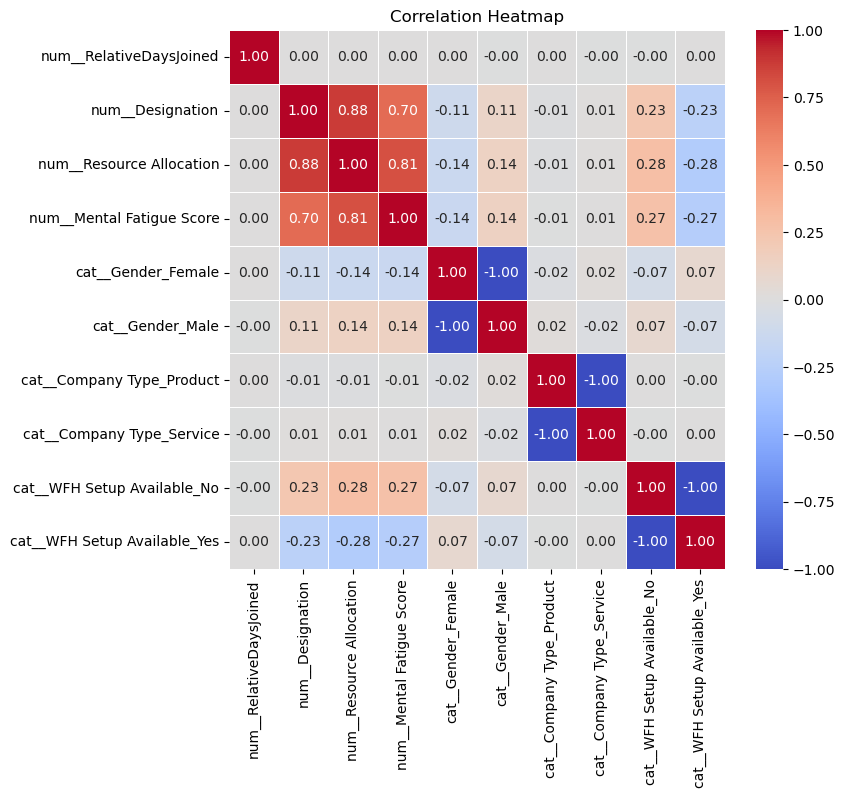

In [110]:
# 독립 변수들 간의 상관관계 행렬 계산
corr_matrix = transformed_X_df_PRE.corr()

# 히트맵 그리기
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,  xticklabels=preprocessor_PRE.get_feature_names_out(), yticklabels=preprocessor_PRE.get_feature_names_out())
plt.title('Correlation Heatmap')
plt.show()

-> 0.7이상으로 독립 변수간 상관계수가 높은 변수들 <br>

* Resource Allocation <-> Designation : 0.88
* Resource Allocation <-> Mental Fatigue Score : 0.8
* Designation <-> Mental Fatigue Score : 0.7

- **Resource Allocation  제거 결정**
- Designation 제거 고민

-------
#### 6-1-2. rfc 최적의 하이퍼 파라미터 찾기 - Random search

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold

# 교차 검증을 위한 StratifiedKFold 사용 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 탐색할 하이퍼파라미터 설정
param_dist = {

    #'clf__max_depth': np.arange(6, 8, 10),
    #'clf__min_samples_leaf': np.arange(8, 12, 18),
    #'clf__min_samples_split': np.arange(8, 16, 20),
    #'clf__n_estimators': np.arange(50, 200, 50)

    
    'model__n_estimators': np.arange(randint(low=100, high=200)),
    'model__max_depth': np.arange(randint(low=1, high=10)),
    'model__min_samples_split': np.arange(randint(low=2, high=20)),
    'model__min_samples_leaf': np.arange(randint(low=1, high=20)),
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 찾기 (n_jobs=-1로 병렬 처리 활성화)
random_search = RandomizedSearchCV(
    RFCmodel_pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)

random_search.fit(train_X, train_y)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)
print('Score: ', random_search.best_score_)

최적의 하이퍼파라미터: {'model__max_depth': 7, 'model__min_samples_leaf': 15, 'model__min_samples_split': 12, 'model__n_estimators': 81}
Score:  0.5434682080924856


In [78]:
rfc_final_model = random_search.best_estimator_

In [101]:
random_search.best_params_

{'model__max_depth': 7,
 'model__min_samples_leaf': 15,
 'model__min_samples_split': 12,
 'model__n_estimators': 81}

In [79]:
rfc_final_model.fit(train_X_smt, train_y_smt)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Designation',
                                                   'Resource Allocation',
                                                   'Mental Fatigue Score'])])),
                ('model',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=16,
                                        min_samples_split=14,
                                        random_state=42))])

In [102]:
rfc_final_model.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Designation',
                                                   'Mental Fatigue Score']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Gender', 'Company Type',
                                                   'WFH Setup Available'])])),
                ('model',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=15,
                                        min_samples_split=12, n_estimators=81,
                                        random_state=42))])

In [103]:
rfc_final_model[2]

RandomForestClassifier(max_depth=7, min_samples_leaf=15, min_samples_split=12,
                       n_estimators=81, random_state=42)

##### 6.4 rfc-best model evaluating 

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_multiclass_model(y_true, y_pred_proba, y_pred):
    """
    평가 지표를 계산하여 출력하는 함수

    Parameters:
    - y_true: 실제 클래스 레이블
    - y_pred_proba: 모델의 클래스별 예측 확률
    - y_pred: 모델의 예측 클래스

    Returns:
    - None
    """
    # 정확도 (Accuracy)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # 정밀도 (Precision), 재현율 (Recall), F1 스코어 (F1 Score)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # 다중 클래스 로그 손실 (Log Loss)
    logloss = log_loss(y_true, y_pred_proba)
    print(f"Log Loss: {logloss:.4f}")

    # 혼동 행렬 (Confusion Matrix)
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # 클래스별 정밀도, 재현율, F1 스코어
    class_report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(class_report)

In [ ]:
train_X_smt, train_y_smt

In [81]:
train_pred = rfc_final_model.predict(train_X_smt)
train_pred_proba = rfc_final_model.predict_proba(train_X_smt)
evaluate_multiclass_model(train_y_smt, train_pred_proba, train_pred)

Accuracy: 0.8680
Precision: 0.8672
Recall: 0.8680
F1 Score: 0.8674
Log Loss: 0.3190
Confusion Matrix:
[[6946  598    0    0]
 [ 780 6146  618    0]
 [   0  577 6124  843]
 [   0    3  564 6977]]
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.92      0.91      7544
           2       0.84      0.81      0.83      7544
           3       0.84      0.81      0.82      7544
           4       0.89      0.92      0.91      7544

    accuracy                           0.87     30176
   macro avg       0.87      0.87      0.87     30176
weighted avg       0.87      0.87      0.87     30176



In [105]:
train_pred = rfc_final_model.predict(train_X)
train_pred_proba = rfc_final_model.predict_proba(train_X)
evaluate_multiclass_model(train_y, train_pred_proba, train_pred)

Accuracy: 0.5609
Precision: 0.5644
Recall: 0.5609
F1 Score: 0.5568
Log Loss: 1.0448
Confusion Matrix:
[[ 572  139   18    9    0    0    0    0    0    0]
 [  98  579  460   36    7    0    0    0    0    0]
 [  32  112 1286  649   74    0    0    0    0    0]
 [   0    1  398 1585  861  140    0    0    0    0]
 [   0    0   18  666 2099  576    5    0    0    0]
 [   0    0    0   69  573 1981  403    7    0    0]
 [   0    0    0    7  133  791 1058  100    0    0]
 [   0    0    0    1    6  158  519  359   36    9]
 [   0    0    0    0    0    9  116  191  133   14]
 [   0    0    0    0    0    1   12   62   80   52]]
Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.78      0.79       738
           2       0.70      0.49      0.58      1180
           3       0.59      0.60      0.59      2153
           4       0.52      0.53      0.53      2985
           5       0.56      0.62      0.59      3364
           6       

### 6-2 **XGBoost**

In [158]:
# pip install xgboost

In [106]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [160]:
# 전처리-모델학습'랜덤포레스트 파이프라인 정의
XGBmodel_pipeline = Pipeline([
    ('imputer_na', impute_NA_pipeline),
    ('preprocessing', preprocessor),
    ('model', XGBClassifier(objective='multi:softmax', num_class=10, seed=42))
])

In [161]:
XGBmodel_pipeline

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RelativeDaysJoined',
                                                   'Designation',
                                                   'Mental...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=10,
                               num_parallel_tree=None, ...))])

In [164]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)

train_y_adjusted = train_y - 1

In [175]:
XGBmodel_pipeline.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RelativeDaysJoined',
                                                   'Designation',
                                                   'Mental...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=10,
                               num_parallel_tree=None, ...))])

#### 6-2-2 xgb-scoring

In [167]:
burnout_predictions = XGBmodel_pipeline.predict(train_X)
burnout_predictions

array([7, 5, 4, ..., 3, 4, 5])

In [168]:
XGBmodel_pipeline.score(train_X, train_y)

0.727514450867052

In [181]:
XGBmodel_pipeline.score(valid_X, valid_y)

0.9091539528432733

In [177]:
# 모델을 훈련 데이터에 맞추기
XGBmodel_pipeline.fit(train_X, train_y)

# 훈련 데이터에 대한 예측 수행
train_pred = XGBmodel_pipeline.predict(train_X)

# 정확도 계산
accuracy = accuracy_score(train_y, train_pred)
print(f'accuracy = {accuracy}')

accuracy = 0.727514450867052


In [179]:
label_encoder = LabelEncoder()
valid_y = label_encoder.fit_transform(valid_y)

valid_y_adjusted = valid_y - 1

In [180]:
# 모델을 훈련 데이터에 맞추기
XGBmodel_pipeline.fit(valid_X, valid_y)

# 훈련 데이터에 대한 예측 수행
valid_pred = XGBmodel_pipeline.predict(valid_X)

# 정확도 계산
accuracy = accuracy_score(valid_y, valid_pred)
print(f'accuracy = {accuracy}')

accuracy = 0.9091539528432733


#### 6-2-3 xgb-최적의 파라미터 찾기 Random search

In [259]:
from scipy.stats import uniform, randint

xgb_param_dist = {
    'model__learning_rate': uniform(0.01, 0.3),  # 학습률
    'model__n_estimators': randint(50, 200),  # 트리의 개수
    'model__max_depth': randint(3, 10),  # 트리의 최대 깊이
    'model__subsample': uniform(0.6, 0.4),  # 각 트리에서 사용되는 데이터 샘플의 비율
    'model__colsample_bytree': uniform(0.6, 0.4)  # 각 트리에서 사용되는 특성의 비율
}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(
    XGBmodel_pipeline, param_distributions=xgb_param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

# 랜덤 서치 수행
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
train_y_adjusted = train_y - 1

random_search.fit(train_X, train_y)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)
print('Score: ', random_search.best_score_)

최적의 하이퍼파라미터: {'model__colsample_bytree': 0.9439761626945282, 'model__learning_rate': 0.2140922615763339, 'model__max_depth': 3, 'model__n_estimators': 67, 'model__subsample': 0.9795542149013333}
Score:  0.5530635838150288


In [260]:
xgb_final_model = random_search.best_estimator_

In [261]:
random_search.best_params_

{'model__colsample_bytree': 0.9439761626945282,
 'model__learning_rate': 0.2140922615763339,
 'model__max_depth': 3,
 'model__n_estimators': 67,
 'model__subsample': 0.9795542149013333}

In [262]:
xgb_final_model.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RelativeDaysJoined',
                                                   'Designation',
                                                   'Mental...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.2140922615763339, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=67,
                               n_jobs=None, num_class=10,
                               num_parallel_tree=None, ...))])

In [263]:
xgb_final_model.score(train_X, train_y)

0.5698265895953757

In [264]:
#종합적인 성능 평가 

train_pred = xgb_final_model.predict(train_X)
train_pred_proba = xgb_final_model.predict_proba(train_X)
evaluate_multiclass_model(train_y, train_pred_proba, train_pred)

Accuracy: 0.5698
Precision: 0.5745
Recall: 0.5698
F1 Score: 0.5672
Log Loss: 0.9224
Confusion Matrix:
[[ 561  158    9   10    0    0    0    0    0    0]
 [  91  591  460   32    6    0    0    0    0    0]
 [  32  119 1301  630   71    0    0    0    0    0]
 [   0    0  412 1570  858  145    0    0    0    0]
 [   0    0    5  667 2092  593    7    0    0    0]
 [   0    0    0   68  535 2057  365    8    0    0]
 [   0    0    0    7  133  830 1004  115    0    0]
 [   0    0    0    1    6  185  434  404   48   10]
 [   0    0    0    0    0   13   81  166  183   20]
 [   0    0    0    0    0    1    1   40   70   95]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       738
           1       0.68      0.50      0.58      1180
           2       0.59      0.60      0.60      2153
           3       0.53      0.53      0.53      2985
           4       0.57      0.62      0.59      3364
           5       

#### 6-3. **Gradient Boosting**

In [195]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting 모델을 사용한 파이프라인 정의
GBTmodel_pipeline = Pipeline([
    ('imputer_na', impute_NA_pipeline),
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

In [197]:
GBTmodel_pipeline.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RelativeDaysJoined',
                                                   'Designation',
                                                   'Mental Fatigue Score']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Gender', 'Company Type',
                                                   'WFH Setup Available'])])),
                ('model', GradientBoostingClassifier(random_state=42))])

#### 6-3-2 GBT-scoring

In [198]:
burnout_predictions = GBTmodel_pipeline.predict(train_X)
burnout_predictions

array([7, 5, 4, ..., 3, 4, 5], dtype=int64)

In [199]:
GBTmodel_pipeline.score(train_X, train_y)

0.5882080924855492

In [203]:
GBTmodel_pipeline.score(valid_X, valid_y)

0.6560332871012483

In [201]:
# 모델을 훈련 데이터에 맞추기
GBTmodel_pipeline.fit(train_X, train_y)

# 훈련 데이터에 대한 예측 수행
train_pred = GBTmodel_pipeline.predict(train_X)

# 정확도 계산
accuracy = accuracy_score(train_y, train_pred)
print(f'accuracy = {accuracy}')

accuracy = 0.5882080924855492


In [202]:
# 모델을 훈련 데이터에 맞추기
GBTmodel_pipeline.fit(valid_X, valid_y)

# 훈련 데이터에 대한 예측 수행
valid_pred = GBTmodel_pipeline.predict(valid_X)

# 정확도 계산
accuracy = accuracy_score(valid_y, valid_pred)
print(f'accuracy = {accuracy}')

accuracy = 0.6560332871012483


#### 6-3-3 gbt-최적의 파라미터 찾기 Random search

In [255]:
from scipy.stats import uniform, randint

# 랜덤 서치를 위한 하이퍼파라미터 범위 정의
param_dist = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'model__max_depth': [3, 5, 7, 9],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(
    GBTmodel_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)


random_search.fit(train_X, train_y)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)
print('Score: ', random_search.best_score_)

최적의 하이퍼파라미터: {'model__subsample': 0.9, 'model__n_estimators': 50, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 5, 'model__learning_rate': 0.01}
Score:  0.5333526011560694


In [271]:
gbt_final_model = random_search.best_estimator_

In [272]:
random_search.best_params_

{'model__colsample_bytree': 0.9439761626945282,
 'model__learning_rate': 0.2140922615763339,
 'model__max_depth': 3,
 'model__n_estimators': 67,
 'model__subsample': 0.9795542149013333}

In [273]:
gbt_final_model.fit(train_X, train_y)

Pipeline(steps=[('imputer_na',
                 Pipeline(steps=[('impute_RA',
                                  ImputeGroupbyMode(group='Designation',
                                                    nan_feature='Resource '
                                                                'Allocation')),
                                 ('impute_MF',
                                  ImputeGroupbyMode(group='Resource Allocation',
                                                    nan_feature='Mental '
                                                                'Fatigue '
                                                                'Score'))])),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RelativeDaysJoined',
                                                   'Designation',
                                                   'Mental...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.2140922615763339, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=67,
                               n_jobs=None, num_class=10,
                               num_parallel_tree=None, ...))])

In [274]:
gbt_final_model.score(train_X, train_y)

0.5698265895953757

In [275]:
#종합적인 성능 평가 

train_pred = gbt_final_model.predict(train_X)
train_pred_proba = gbt_final_model.predict_proba(train_X)
evaluate_multiclass_model(train_y, train_pred_proba, train_pred)

Accuracy: 0.5698
Precision: 0.5745
Recall: 0.5698
F1 Score: 0.5672
Log Loss: 0.9224
Confusion Matrix:
[[ 561  158    9   10    0    0    0    0    0    0]
 [  91  591  460   32    6    0    0    0    0    0]
 [  32  119 1301  630   71    0    0    0    0    0]
 [   0    0  412 1570  858  145    0    0    0    0]
 [   0    0    5  667 2092  593    7    0    0    0]
 [   0    0    0   68  535 2057  365    8    0    0]
 [   0    0    0    7  133  830 1004  115    0    0]
 [   0    0    0    1    6  185  434  404   48   10]
 [   0    0    0    0    0   13   81  166  183   20]
 [   0    0    0    0    0    1    1   40   70   95]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       738
           1       0.68      0.50      0.58      1180
           2       0.59      0.60      0.60      2153
           3       0.53      0.53      0.53      2985
           4       0.57      0.62      0.59      3364
           5       

## **Presentation of model results** 모델 결과 정리

- 최종 성능 지표 : F1 score (recall / precision 의 조합평균)
- 성능 지표 선정 이유 : 레이블에 불균형이 있어 클래스의 샘플 수에 따라 가중 평균을 계산하는 F1 score(average='weighted') 사용

In [277]:
from sklearn.metrics import f1_score
def calculate_f1_score(model, X, y):
    """
    모델 예측값을 얻어 F1 스코어 반환하는 함수
    """
    # 모델의 예측값 얻기
    y_pred = model.predict(X)

    # F1 스코어 계산
    f1 = f1_score(y, y_pred, average='weighted') 

    return f1

In [307]:
rfc_f1 = calculate_f1_score(rfc_final_model, valid_X, valid_y)
rfc_weights_f1 = calculate_f1_score(RFCmodel_pipeline_weights , valid_X, valid_y)
gbt_f1 = calculate_f1_score(gbt_final_model, valid_X, valid_y)
xgb_f1 = calculate_f1_score(xgb_final_model , valid_X, valid_y)


print(f'rfc_final_model = {rfc_f1:.3f}')
print(f'RFCmodel_weights = {rfc_weights_f1:.3f}')
print(f'gbt_final_model = {gbt_f1:.3f}')
print(f'xgb_final_model = {xgb_f1:.3f}')

rfc_final_model = 0.529
RFCmodel_weights = 0.491
gbt_final_model = 0.534
xgb_final_model = 0.534
